# Dogs vs. Cats
### Author: Bryce Freshcorn
This Jupyter notebook is a demonstration of transfer learning for image classification with InceptionV3.  The images used ared from the [Kaggle's Dogs vs. Cats dataset](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition).

In [1]:
%matplotlib inline
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import load_model, Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
train_dir = 'data/train'
validation_dir = 'data/validation'
test_dir = 'data/test'

#### Perform data augmentation on the training set to generate more training data with particular deformations.

In [3]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

The below image is an original image of a cat from the training set.

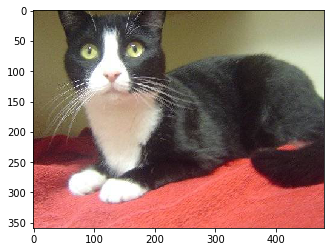

In [4]:
x = image.load_img(train_dir + '/cat/cat.800.jpg')
plt.imshow(x)
x = image.img_to_array(x)
x = x.reshape((1,) + x.shape)

Here you can see eight examples of the different ways the image is modified to increase the size of the training set. Another way to think about this is that by performing data augmentation, we are teaching the convolutional neural network that a cat is still a cat when these various transformations are applied to the image.

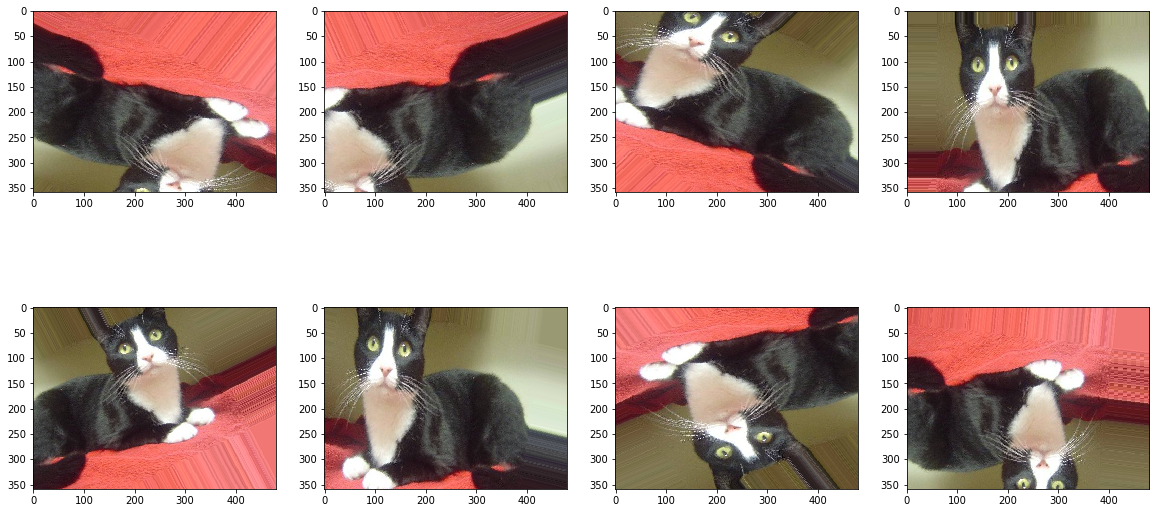

In [5]:
plt.figure(figsize=(20,10))
i = 0
for img in train_datagen.flow(x, batch_size=1):
    i += 1
    if i > 8:
        break
    plt.subplot(2, 4, i)
    plt.imshow(img[0])

Below is another example of how data augmentation creates new images through transformations of a random subset of the training data.

Found 22618 images belonging to 2 classes.


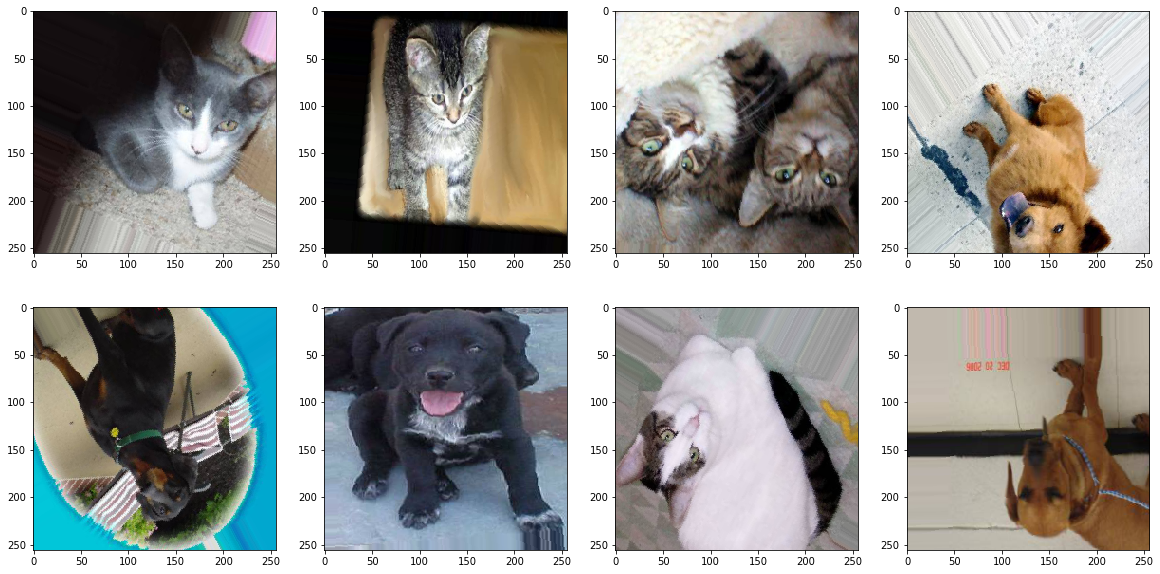

In [6]:
plt.figure(figsize=(20,10))
i = 0
for batch in train_datagen.flow_from_directory(train_dir,
                                               batch_size=8,
                                               class_mode=None):
    i = 0
    for img in batch:
        i += 1
        if i > 8:
            break
        plt.subplot(2, 4, i)
        plt.imshow(img)
    break

In [7]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=128,
                                                    target_size=(224, 224),
                                                    class_mode='categorical')
valid_generator = test_datagen.flow_from_directory(validation_dir,
                                                   batch_size=128,
                                                   target_size=(224, 224),
                                                   class_mode='categorical',
                                                   shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=128,
                                                  target_size=(224, 224),
                                                  classes=None,
                                                  class_mode=None,
                                                  shuffle=False)

Found 22618 images belonging to 2 classes.
Found 2382 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [8]:
base_model = VGG16(weights='imagenet')
base_model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
blo

In [9]:
base_model.layers.pop()
for layer in base_model.layers:
    layer.trainable = False
last = base_model.layers[-1].output
preds = Dense(2, activation='softmax', name='predictions')(last)
model = Model(base_model.input, preds)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
callbacks = [EarlyStopping(min_delta=0.001, patience=10, verbose=2)]

In [12]:
model.fit_generator(train_generator, steps_per_epoch=177,
                    epochs=50, verbose=1, validation_data=valid_generator,
                    validation_steps=19, max_queue_size=1, callbacks=callbacks)

Epoch 1/50
177/177 [==============================] - 201s 1s/step - loss: 0.5785 - acc: 0.7057 - val_loss: 0.3591 - val_acc: 0.8514
Epoch 2/50
177/177 [==============================] - 196s 1s/step - loss: 0.4800 - acc: 0.7736 - val_loss: 0.3086 - val_acc: 0.8724
Epoch 3/50
177/177 [==============================] - 196s 1s/step - loss: 0.4546 - acc: 0.7874 - val_loss: 0.2902 - val_acc: 0.8787
Epoch 4/50
177/177 [==============================] - 196s 1s/step - loss: 0.4447 - acc: 0.7943 - val_loss: 0.2816 - val_acc: 0.8820
Epoch 5/50
177/177 [==============================] - 196s 1s/step - loss: 0.4346 - acc: 0.7959 - val_loss: 0.2985 - val_acc: 0.8661
Epoch 6/50
177/177 [==============================] - 196s 1s/step - loss: 0.4179 - acc: 0.8095 - val_loss: 0.2976 - val_acc: 0.8694
Epoch 7/50
177/177 [==============================] - 196s 1s/step - loss: 0.4149 - acc: 0.8099 - val_loss: 0.2620 - val_acc: 0.8896
Epoch 8/50
177/177 [==============================] - 196s 1s/step - 

In [13]:
model.save('my_model.h5')